In [1]:
import PIL
PIL.__version__

'9.4.0'

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!ls train

simpsons_dataset


In [6]:
!nvidia-smi
torch.cuda.is_available()

Wed Dec 13 15:12:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [7]:
import time
import pickle
import numpy as np
from skimage import io
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


<ipython-input-7-6c7ea0fb49b0>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [8]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

In [9]:
class SimpsonsDataset(Dataset):
    """
    A dataset with pictures that simultaneously loads them from folders, scaling them and turning them into torsional tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # list of files to download
        self.files = sorted(files)
        # operating mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # to convert images to PyTorch tensors and normalize input
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.20, \
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

### Let's take a look at our heroes inside the dataset.

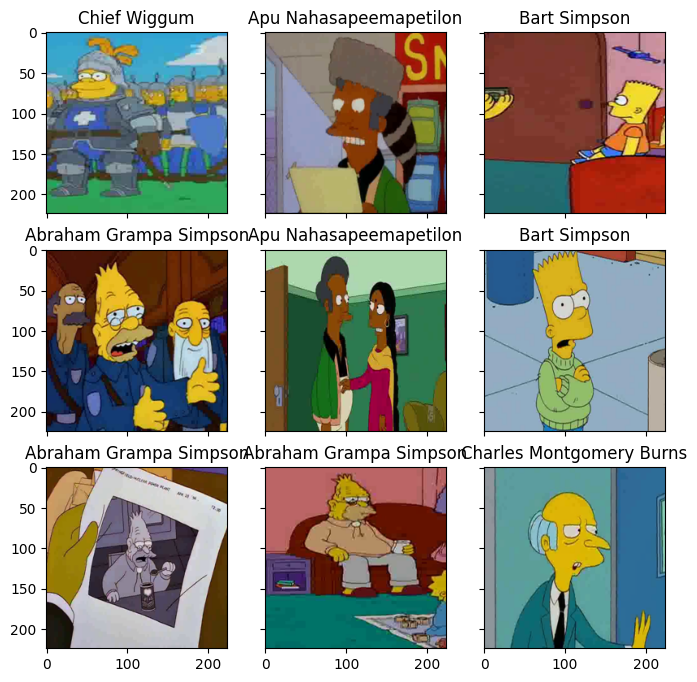

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
# building our model

class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

### Let's start training the network

In [21]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [22]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.597037240565642

Epoch 001 train_loss: 2.5970     val_loss 1.9638 train_acc 0.2695 val_acc 0.4770
loss 1.5471432114478922

Epoch 002 train_loss: 1.5471     val_loss 1.3696 train_acc 0.5696 val_acc 0.6451


### Let's build learning curves

In [23]:
loss, acc, val_loss, val_acc = zip(*history)

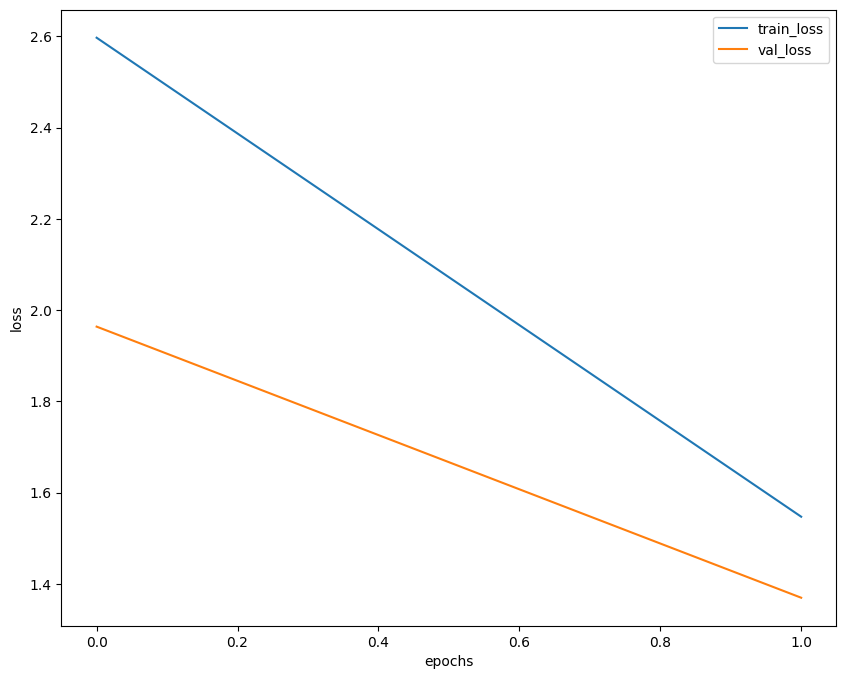

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Transfer learning

### Create a new class and add augmentations to it (horizontal rotation, brightness change)

In [25]:
class SimpsonsDatasetAug(Dataset):
    """
    A dataset with pictures, which simultaneously loads them from folders, scaling and turning them into torsional tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # list of files to download
        self.files = sorted(files)
        # operating mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # to convert images to PyTorch tensors and normalize input
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return Image.fromarray(np.uint8(image))

In [26]:
# We create a test dataset without augmentations, and a training dataset with augmentations.
val_dataset1 = SimpsonsDataset(val_files, mode='val')
if val_dataset1 is None:
    val_dataset1 = SimpsonsDataset(val_files, mode='val')

train_dataset1 = SimpsonsDatasetAug(train_files, mode='train')

In [ ]:
# model = models.efficientnet_b2(pretrained=True)

In [50]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:00


In [51]:
import timm

In [ ]:
#model = timm.create_model("efficientnet_b2", pretrained=True)

In [53]:
model = timm.create_model("efficientnet_b2", pretrained=True)

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [ ]:
#model = models.resnet50(pretrained=True)

In [27]:
'''
from torchvision.models import resnet101, ResNet101_Weights

# Load the pretrained ResNet-101 model
model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 55.2MB/s]


In [ ]:
#model = models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [55]:
num_features = 1408
model.classifier = nn.Linear(num_features, 42)
model = model.cuda()

In [29]:
#num_features = model.fc.in_features
#model.fc = nn.Linear(num_features, 42)
#model = model.cuda()


In [56]:
history1 = train(train_dataset1, val_dataset1, model=model, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.4482946586698938

Epoch 001 train_loss: 0.4483     val_loss 0.1503 train_acc 0.8945 val_acc 0.9630
loss 0.31712044840977777

Epoch 002 train_loss: 0.3171     val_loss 0.1706 train_acc 0.9185 val_acc 0.9546
loss 0.15007071591051452

Epoch 003 train_loss: 0.1501     val_loss 0.1768 train_acc 0.9607 val_acc 0.9565
loss 0.15704878186723614

Epoch 004 train_loss: 0.1570     val_loss 0.1615 train_acc 0.9620 val_acc 0.9587
loss 0.10294212696516114

Epoch 005 train_loss: 0.1029     val_loss 0.1366 train_acc 0.9724 val_acc 0.9673
loss 0.08669268361851261

Epoch 006 train_loss: 0.0867     val_loss 0.1767 train_acc 0.9774 val_acc 0.9568
loss 0.09146628921472669

Epoch 007 train_loss: 0.0915     val_loss 0.2177 train_acc 0.9753 val_acc 0.9453
loss 0.09377183393756221

Epoch 008 train_loss: 0.0938     val_loss 0.1953 train_acc 0.9756 val_acc 0.9527
loss 0.08630444852395677

Epoch 009 train_loss: 0.0863     val_loss 0.2234 train_acc 0.9772 val_acc 0.9477
loss 0.07853069236382146

Epoch 010 tr

In [57]:
loss, acc, val_loss, val_acc = zip(*history1)

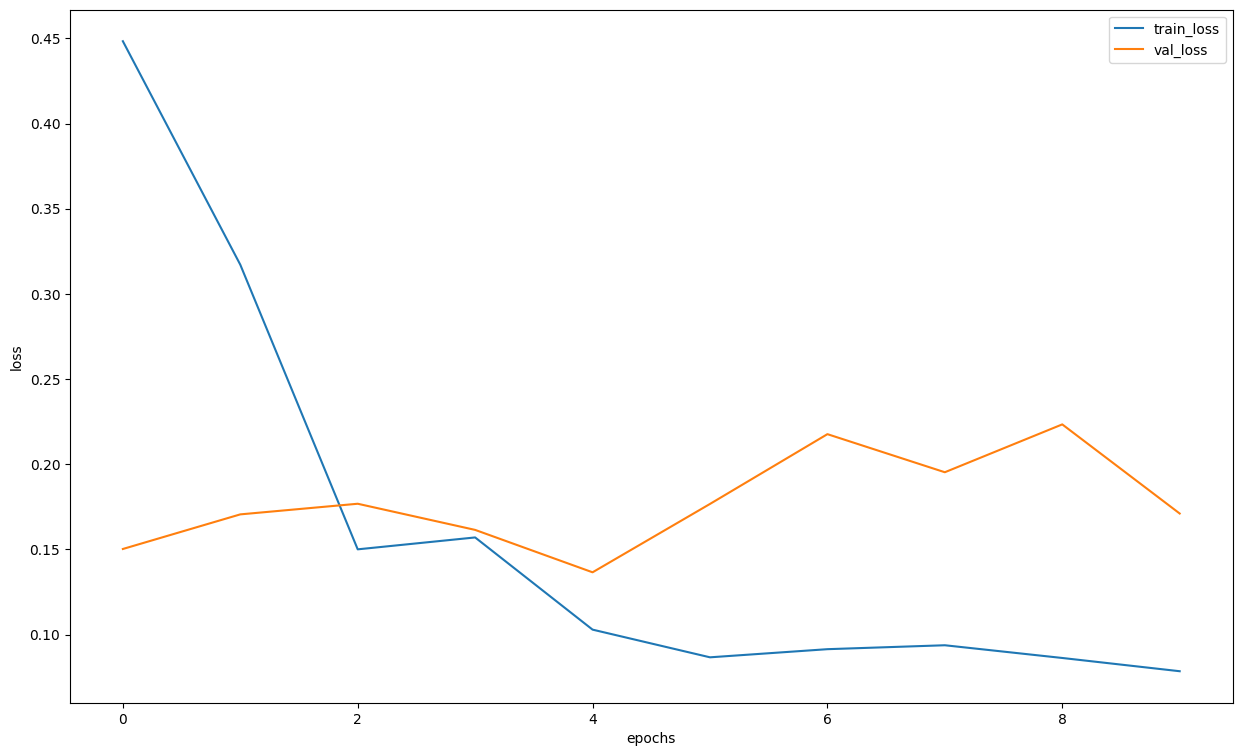

In [58]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [59]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Prediction, for one picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [60]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset1[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [61]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset1[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [62]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [63]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset1[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [64]:
from sklearn.metrics import f1_score
f1_score(actual_labels, list(y_pred), average='macro')

1.0

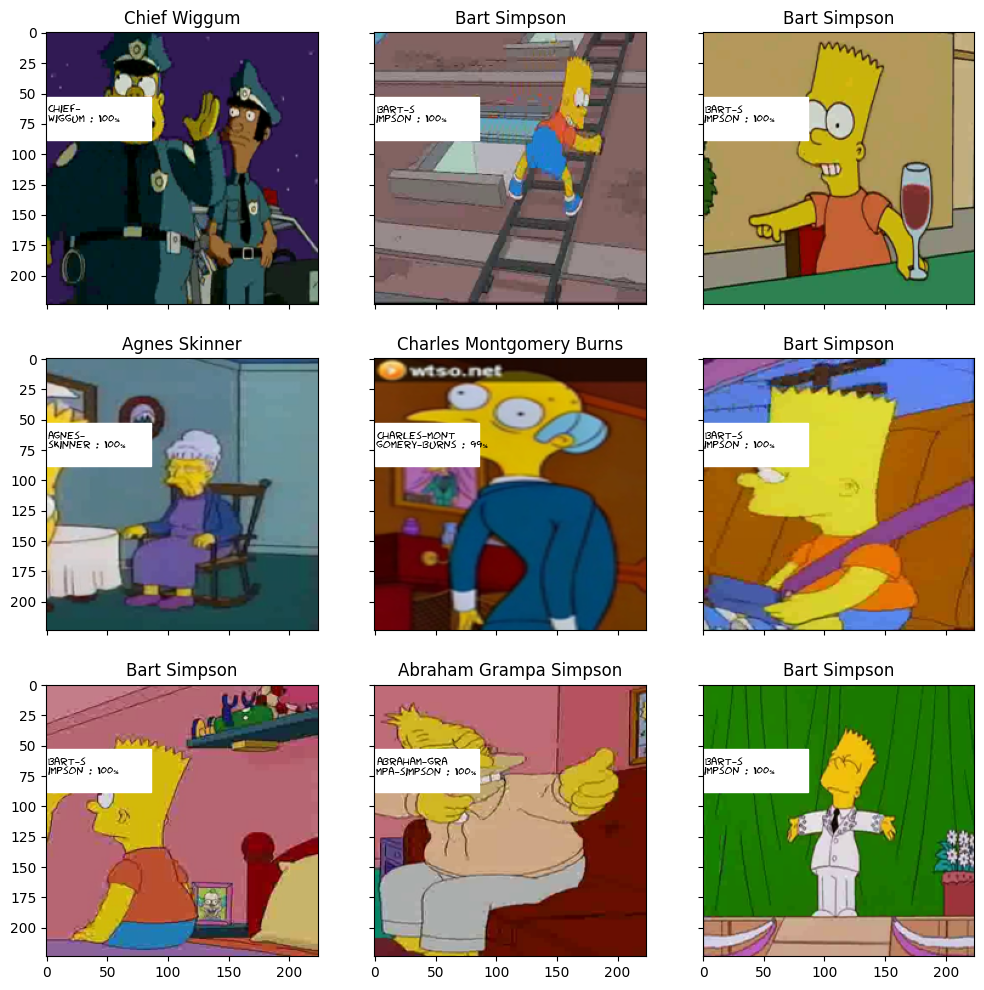

In [65]:
from matplotlib.font_manager import FontProperties
import matplotlib.patches as patches

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset1[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset1.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')